In [1]:
import keras
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense
from keras.models import Model

import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

import seaborn as sns

/home/garipovazamat/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
batch_size = 100
train_len = 2000
test_len = 800

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

## Xception
Использую предобученную модель xception для получения признаков картинок из тренировочного набора

In [4]:
train_generator = train_datagen.flow_from_directory(
    '/home/garipovazamat/cat_dog_classification/train',
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

xception_features = []
classes = []
xception_base_model = Xception()
xception_model = Model(inputs=xception_base_model.input, outputs=xception_base_model.get_layer('avg_pool').output)

batches = 0
for x_batch, y_batch in train_generator:
    batches += 1
    predicted = xception_model.predict_on_batch(x_batch)
    xception_features.append(predicted)
    
    classes.append(y_batch)
    if batches >= train_len / batch_size:
        break
        
xception_features = np.vstack(xception_features)
classes = np.hstack(classes)

Found 2000 images belonging to 2 classes.


## Визуализация

In [5]:
tsne = sklearn.manifold.TSNE(n_components=2)
tsne_data = tsne.fit_transform(xception_features)

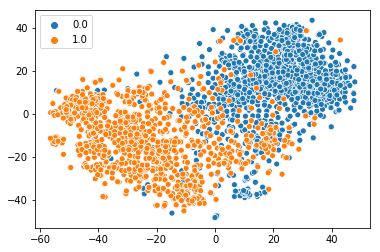

In [6]:
import seaborn
seaborn.scatterplot(tsne_data[:,0], tsne_data[:,1], hue=classes)

Зависимость похоже не линейная, хотя близка к ней

# Обучение и оценка

In [7]:
print 'sgd: '
sgd = SGDClassifier(max_iter=1000, penalty='l2', random_state=42)
scores = cross_val_score(sgd, xception_features, classes, scoring='accuracy', n_jobs=-1)
print scores.mean()

sgd: 
0.8679997362632094


In [10]:
print 'random forest: '
xgb = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
scores = cross_val_score(xgb, xception_features, classes, scoring='accuracy', n_jobs=-1)
print scores.mean()

random forest: 
0.8900142657627687


In [27]:
print 'xgboost: '
xgb = xgboost.XGBClassifier(max_depth=2, n_estimators=1000, random_state=42)
scores = cross_val_score(xgb, xception_features, classes, scoring='accuracy', n_jobs=-1)
print scores.mean()

xgboost: 
0.8940167712622803


xgboost дает лучшую оценку

#### Подбор параметров для XGBoost

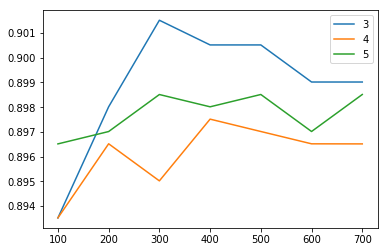

In [28]:
import warnings
warnings.filterwarnings("ignore")

for depth in range(3, 6):
    scores = []
    for trees in range(100, 800, 100):
        xgb = xgboost.XGBClassifier(max_depth=depth, n_estimators=trees, random_state=42)
        score = cross_val_score(xgb, xception_features, classes, scoring='accuracy', n_jobs=-1, cv=3).mean()
        scores.append(score)
    plt.plot(range(100, 800, 100), scores, label=depth)
plt.legend()
plt.show()

## проверка на тестовой выборке

In [29]:
xgb = xgboost.XGBClassifier(max_depth=3, n_estimators=300, n_jobs=-1)
xgb.fit(xception_features, classes)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [30]:
test_generator = train_datagen.flow_from_directory(
    '/home/garipovazamat/cat_dog_classification/test',
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

batches = 0
xception_validation_features = []
validation_classes = []
for x_batch, y_batch in test_generator:
    batches += 1
    predicted = xception_model.predict_on_batch(x_batch)
    xception_validation_features.append(predicted)
    validation_classes.append(y_batch)
    if batches >= test_len / batch_size:
        break

xception_validation_features = np.vstack(xception_validation_features)
validation_classes = np.hstack(validation_classes)

Found 800 images belonging to 2 classes.


In [32]:
preds = xgb.predict(xception_validation_features)
print "Accuracy на тестовой выборке: " + str(accuracy_score(validation_classes, preds))

Accuracy на тестовой выборке: 0.9075
